In [1]:
!pip install torchcp
!pip install --index-url https://test.pypi.org/simple/ --no-deps torchcp

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://test.pypi.org/simple/, https://pypi.ngc.nvidia.com


In [2]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models, transforms, datasets
import torchvision
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import SplitPredictor, ClassWisePredictor, ClusterPredictor

# Dataset

In [105]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])
])

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# cal_dataset = torchvision.datasets.Flowers102(root='../data', split='val',
#                                         download=True, transform=transform)
# cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64,
#                                           shuffle=True, num_workers=2)

# test_dataset = torchvision.datasets.Flowers102(root='../data', split='test',
#                                        download=True, transform=transform)
# test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
#                                          shuffle=False, num_workers=2)
dataset = torchvision.datasets.Flowers102(root='../data', split='test',
                                        download=True, transform=transform)
cal_dataset_len=int(0.5*len(dataset))
test_dataset_len=len(dataset)-cal_dataset_len
print(cal_dataset_len,test_dataset_len)
cal_dataset, test_dataset = torch.utils.data.random_split(dataset, [cal_dataset_len,test_dataset_len])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

resnet = models.resnet50()
resnet.fc = nn.Linear(resnet.fc.in_features, 102)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

model = resnet
model.eval()

coverage_rates=[]
average_sizes=[]
#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
model_name="Resnet"
alpha=0.05
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])
predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
score_functions = [THR(),  RAPS(1, 0), SAPS(0.2)] 
for score in score_functions: 
    for predictor in predictors:
        predictor = predictor(score, model)
        predictor.calibrate(cal_data_loader, alpha)
        print(f"Experiment--Data : Flower102, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
        print(predictor.evaluate(test_data_loader))
        result=predictor.evaluate(test_data_loader)
        coverage_rate = result['Coverage_rate']
        average_size = result['Average_size']
        coverage_rates.append(coverage_rate)
        average_sizes.append(average_size)

3074 3075
Experiment--Data : Flower102, Model : Resnet, Score : THR, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.07642276422764227, 'Average_size': 9.904715447154471}
Experiment--Data : Flower102, Model : Resnet, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.07577235772357724, 'Average_size': 8.856910569105692}


/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/cluster.py:82: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=int(self.__num_clusters), n_init=10).fit(X=embeddings.detach().cpu().numpy(),


Experiment--Data : Flower102, Model : Resnet, Score : THR, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.08195121951219513, 'Average_size': 9.949593495934959}
Experiment--Data : Flower102, Model : Resnet, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.9544715447154472, 'Average_size': 98.0}
Experiment--Data : Flower102, Model : Resnet, Score : RAPS, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.8143089430894309, 'Average_size': 79.9339837398374}
Experiment--Data : Flower102, Model : Resnet, Score : RAPS, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.9515447154471545, 'Average_size': 97.46308943089431}
Experiment--Data : Flower102, Model : Resnet, Score : SAPS, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.9596747967479675, 'Average_size': 98.43642276422764}
Experiment--Data : Flower102, Model : Resnet, Score : SAPS, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.95089430894

/tmp/ipykernel_43131/2962826404.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_coverage = cm.get_cmap('Blues')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_43131/2962826404.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_size = cm.get_cmap('Greens')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


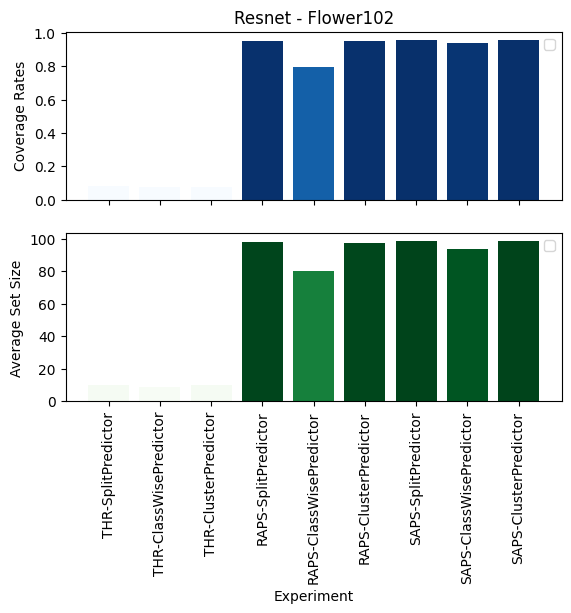

In [106]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

labels = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor',
          'RAPS-SplitPredictor', 'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor',
          'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor']

bar_width = 0.35
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

norm_coverage = Normalize(vmin=min(coverage_rates), vmax=max(coverage_rates))
color_map_coverage = cm.get_cmap('Blues')
colors_coverage = [color_map_coverage(norm_coverage(value)) for value in coverage_rates]
ax1.bar(labels, coverage_rates,  color=colors_coverage)
ax1.set_title(f'{model_name} - '"Flower102")
ax1.set_ylabel('Coverage Rates')
ax1.legend()

norm_size = Normalize(vmin=min(average_sizes), vmax=max(average_sizes))
color_map_size = cm.get_cmap('Greens')
colors_size = [color_map_size(norm_size(value)) for value in average_sizes]
ax2.bar(labels, average_sizes,  color=colors_size)
ax2.set_xlabel('Experiment')
ax2.set_ylabel('Average Set Size')
ax2.legend()

plt.xticks(rotation='vertical')
plt.show()


In [103]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

dataset = torchvision.datasets.CIFAR100(root='../data', train=False,
                                        download=True, transform=transform)
cal_dataset_len=int(0.5*len(dataset))
test_dataset_len=len(dataset)-cal_dataset_len
print(cal_dataset_len,test_dataset_len)
cal_dataset, test_dataset = torch.utils.data.random_split(dataset, [cal_dataset_len,test_dataset_len])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=128, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

resnet = models.resnet50()
resnet.fc = nn.Linear(resnet.fc.in_features, 100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

model = resnet
model.eval()
coverage_rates=[]
average_sizes=[]
#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
model_name="Resnet"
alpha=0.05
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])
predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
score_functions = [THR(),  RAPS(1, 0), SAPS(0.2)] 
for score in score_functions: 
    for predictor in predictors:
        predictor = predictor(score, model)
        predictor.calibrate(cal_data_loader, alpha)
        print(f"Experiment--Data : CIFAR100, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
        print(predictor.evaluate(test_data_loader))
        result=predictor.evaluate(test_data_loader)
        coverage_rate = result['Coverage_rate']
        average_size = result['Average_size']
        coverage_rates.append(coverage_rate)
        average_sizes.append(average_size)

Files already downloaded and verified
5000 5000
Experiment--Data : CIFAR100, Model : Resnet, Score : THR, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.955, 'Average_size': 95.0464}
Experiment--Data : CIFAR100, Model : Resnet, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.9592, 'Average_size': 90.8858}
Experiment--Data : CIFAR100, Model : Resnet, Score : THR, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.9438, 'Average_size': 91.9914}
Experiment--Data : CIFAR100, Model : Resnet, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.9518, 'Average_size': 94.5456}
Experiment--Data : CIFAR100, Model : Resnet, Score : RAPS, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.9552, 'Average_size': 94.6464}
Experiment--Data : CIFAR100, Model : Resnet, Score : RAPS, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.9488, 'Average_size': 94.619}
Experiment--Data : CIFAR100, Model : Re

/tmp/ipykernel_43131/3518094504.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_coverage = cm.get_cmap('Blues')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_43131/3518094504.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_size = cm.get_cmap('Greens')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


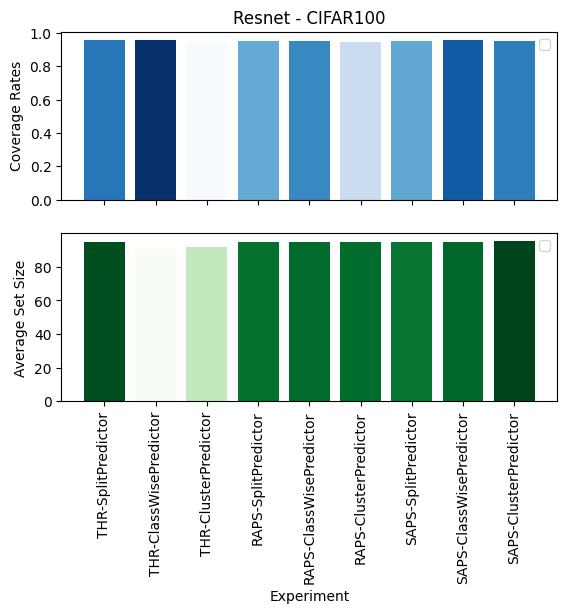

In [104]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

labels = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor',
          'RAPS-SplitPredictor', 'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor',
          'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor']
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

norm_coverage = Normalize(vmin=min(coverage_rates), vmax=max(coverage_rates))
color_map_coverage = cm.get_cmap('Blues')
colors_coverage = [color_map_coverage(norm_coverage(value)) for value in coverage_rates]
ax1.bar(labels, coverage_rates,  color=colors_coverage)
ax1.set_title(f'{model_name} - '"CIFAR100")
ax1.set_ylabel('Coverage Rates')
ax1.legend()

norm_size = Normalize(vmin=min(average_sizes), vmax=max(average_sizes))
color_map_size = cm.get_cmap('Greens')
colors_size = [color_map_size(norm_size(value)) for value in average_sizes]
ax2.bar(labels, average_sizes,  color=colors_size)
ax2.set_xlabel('Experiment')
ax2.set_ylabel('Average Set Size')
ax2.legend()

plt.xticks(rotation='vertical')
plt.show()


In [100]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = torchvision.datasets.FashionMNIST(root='../data', train=False,
                                        download=True, transform=transform)
cal_dataset_len=int(0.5*len(dataset))
test_dataset_len=len(dataset)-cal_dataset_len
print(cal_dataset_len,test_dataset_len)
cal_dataset, test_dataset = torch.utils.data.random_split(dataset, [cal_dataset_len,test_dataset_len])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

resnet = models.resnet50(pretrained=True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

model = resnet
model.eval()

coverage_rates=[]
average_sizes=[]
#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
model_name="Resnet"
alpha=0.05
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])
predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
score_functions = [THR(),  RAPS(1, 0), SAPS(0.2)] 
for score in score_functions: 
    for predictor in predictors:
        predictor = predictor(score, model)
        predictor.calibrate(cal_data_loader, alpha)
        print(f"Experiment--Data : FashionMNIST, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
        print(predictor.evaluate(test_data_loader))
        result=predictor.evaluate(test_data_loader)
        coverage_rate = result['Coverage_rate']
        average_size = result['Average_size']
        coverage_rates.append(coverage_rate)
        average_sizes.append(average_size)

5000 5000


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Experiment--Data : FashionMNIST, Model : Resnet, Score : THR, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.952, 'Average_size': 9.3488}
Experiment--Data : FashionMNIST, Model : Resnet, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.9428, 'Average_size': 8.6526}
Experiment--Data : FashionMNIST, Model : Resnet, Score : THR, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.952, 'Average_size': 9.3464}
Experiment--Data : FashionMNIST, Model : Resnet, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.9522, 'Average_size': 9.5956}
Experiment--Data : FashionMNIST, Model : Resnet, Score : RAPS, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.9568, 'Average_size': 9.5658}
Experiment--Data : FashionMNIST, Model : Resnet, Score : RAPS, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.9508, 'Average_size': 9.5904}
Experiment--Data : FashionMNIST, Model : Resnet, Score : SAPS, Predic

/tmp/ipykernel_43131/3858985409.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_coverage = cm.get_cmap('Blues')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_43131/3858985409.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_size = cm.get_cmap('Greens')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


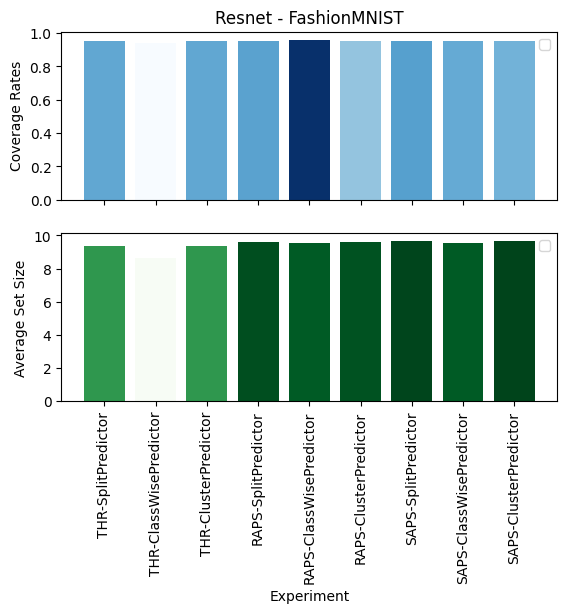

In [102]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

labels = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor',
          'RAPS-SplitPredictor', 'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor',
          'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor']

num_experiments = len(coverage_rates)

bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

norm_coverage = Normalize(vmin=min(coverage_rates), vmax=max(coverage_rates))
color_map_coverage = cm.get_cmap('Blues')
colors_coverage = [color_map_coverage(norm_coverage(value)) for value in coverage_rates]
ax1.bar(labels, coverage_rates, color=colors_coverage)
ax1.set_title(f'{model_name} - '"FashionMNIST")
ax1.set_ylabel('Coverage Rates')
ax1.legend()

norm_size = Normalize(vmin=min(average_sizes), vmax=max(average_sizes))
color_map_size = cm.get_cmap('Greens')
colors_size = [color_map_size(norm_size(value)) for value in average_sizes]
ax2.bar(labels, average_sizes, color=colors_size)
ax2.set_xlabel('Experiment')
ax2.set_ylabel('Average Set Size')
ax2.legend()

plt.xticks(rotation='vertical')
plt.show()

In [107]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform)
cal_dataset_len=int(0.5*len(dataset))
test_dataset_len=len(dataset)-cal_dataset_len
print(cal_dataset_len,test_dataset_len)
cal_dataset, test_dataset = torch.utils.data.random_split(dataset, [cal_dataset_len,test_dataset_len])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

resnet = models.resnet50(pretrained=True)
new_conv1_weight = torch.nn.Parameter(resnet.conv1.weight[:, :3, :, :])
resnet.conv1.weight = new_conv1_weight
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

model = resnet
model.eval()

coverage_rates=[]
average_sizes=[]
#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
model_name="Resnet"
alpha=0.05
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])
predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
score_functions = [THR(),  RAPS(1, 0), SAPS(0.2)] 
for score in score_functions: 
    for predictor in predictors:
        predictor = predictor(score, model)
        predictor.calibrate(cal_data_loader, alpha)
        print(f"Experiment--Data : FashionMNIST, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
        print(predictor.evaluate(test_data_loader))
        result=predictor.evaluate(test_data_loader)
        coverage_rate = result['Coverage_rate']
        average_size = result['Average_size']
        coverage_rates.append(coverage_rate)
        average_sizes.append(average_size)

Files already downloaded and verified
5000 5000


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Experiment--Data : FashionMNIST, Model : Resnet, Score : THR, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.9576, 'Average_size': 9.3066}
Experiment--Data : FashionMNIST, Model : Resnet, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.9518, 'Average_size': 9.2922}
Experiment--Data : FashionMNIST, Model : Resnet, Score : THR, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.9566, 'Average_size': 9.2772}
Experiment--Data : FashionMNIST, Model : Resnet, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.05
{'Coverage_rate': 0.9502, 'Average_size': 9.3012}
Experiment--Data : FashionMNIST, Model : Resnet, Score : RAPS, Predictor : ClassWisePredictor, Alpha : 0.05
{'Coverage_rate': 0.9492, 'Average_size': 9.2708}
Experiment--Data : FashionMNIST, Model : Resnet, Score : RAPS, Predictor : ClusterPredictor, Alpha : 0.05
{'Coverage_rate': 0.9504, 'Average_size': 9.259}
Experiment--Data : FashionMNIST, Model : Resnet, Score : SAPS, Predi

/tmp/ipykernel_43131/337576294.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_coverage = cm.get_cmap('Blues')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_43131/337576294.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map_size = cm.get_cmap('Greens')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


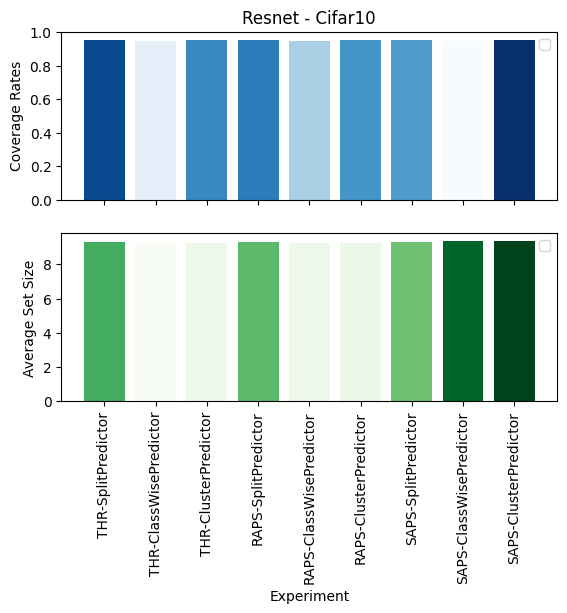

In [108]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

labels = ['THR-SplitPredictor', 'THR-ClassWisePredictor', 'THR-ClusterPredictor',
          'RAPS-SplitPredictor', 'RAPS-ClassWisePredictor', 'RAPS-ClusterPredictor',
          'SAPS-SplitPredictor', 'SAPS-ClassWisePredictor', 'SAPS-ClusterPredictor']

num_experiments = len(coverage_rates)

bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

norm_coverage = Normalize(vmin=min(coverage_rates), vmax=max(coverage_rates))
color_map_coverage = cm.get_cmap('Blues')
colors_coverage = [color_map_coverage(norm_coverage(value)) for value in coverage_rates]
ax1.bar(labels, coverage_rates,  color=colors_coverage)
ax1.set_title(f'{model_name} - '"Cifar10")
ax1.set_ylabel('Coverage Rates')
ax1.legend()

norm_size = Normalize(vmin=min(average_sizes), vmax=max(average_sizes))
color_map_size = cm.get_cmap('Greens')
colors_size = [color_map_size(norm_size(value)) for value in average_sizes]
ax2.bar(labels, average_sizes,  color=colors_size)
ax2.set_xlabel('Experiment')
ax2.set_ylabel('Average Set Size')
ax2.legend()

plt.xticks(rotation='vertical')
plt.show()